# Image Matching Algorithms

## Prerequisites

Understand `fftconvolve` and what's behind.

### 1-D

In [6]:
import numpy as np
from scipy.signal import fftconvolve
from scipy.fft import fft, ifft

In [40]:
a = (1, 2, 3)
b = (4, 5, 6)

In [41]:
np.convolve(a, b)

array([ 4, 13, 28, 27, 18])

In [42]:
fft_1_d = fftconvolve(a, b, mode="full")
print(fft_1_d)

[ 4. 13. 28. 27. 18.]


In [54]:
manual_fft_1_d = np.real(ifft(fft(np.pad(a, (0, len(b) - 1))) * fft(np.pad(b, (0, len(a) - 1)))))
print(manual_fft_1_d)

[ 4. 13. 28. 27. 18.]


### 2-D

In [56]:
from scipy.fft import fft2, ifft2
from scipy.signal import fftconvolve

In [92]:
# a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# b = np.array([[2, 7, 1], [8, 5, 3], [4, 6, 9]])

m, n = 2, 2
A = np.random.randint(1, 10, size=(m, n))
B = np.random.randint(1, 10, size=(m, n))
print("A", A)
print("B", B)

A [[8 5]
 [3 4]]
B [[7 1]
 [4 9]]


In [93]:
fft_2_d = fftconvolve(A, B, mode="full")
print(fft_2_d)

[[ 56.  43.   5.]
 [ 53. 123.  49.]
 [ 12.  43.  36.]]


In [94]:
manual_fft_2_d = np.real(ifft2(fft2(np.pad(A, ((0, m - 1), (0, n - 1)))) * fft2(np.pad(B, ((0, m - 1), (0, n - 1))))))
print(manual_fft_2_d)

[[ 56.  43.   5.]
 [ 53. 123.  49.]
 [ 12.  43.  36.]]


## Image Matching

> Let's firstly assume A.shape == B.shape

### Data

In [120]:
A = [[8, 5], [3, 4]]
B = [[7, 1], [4, 9]]
A = np.array(A)
B = np.array(B)

In [129]:
A, B = [[8, 5, 1], [3, 4, 6], [2, 7, 9]], [[7, 1, 3], [6, 5, 2], [4, 8, 9]]
A = np.array(A)
B = np.array(B)
print(A)
print(B)

[[8 5 1]
 [3 4 6]
 [2 7 9]]
[[7 1 3]
 [6 5 2]
 [4 8 9]]


### O(N^4) implementation

#### Make Sure Indexes Are Correct

In [117]:
def _correlate(A, B):
    # A remains stable and B moves over A. The top left element of the result will be B[-1][-1] * A[0][0].
    if isinstance(A, list):
        A = np.array(A)
    if isinstance(B, list):
        B = np.array(B)

    rows, cols = A.shape
    conv_rows = 2 * rows - 1
    conv_cols = 2 * cols - 1
    result = np.zeros((conv_rows, conv_cols), dtype=A.dtype)  # A and B have the same shape

    # outer loop
    for i in range(0, conv_rows):
        for j in range(0, conv_cols):
            r_offset = i + (-(rows - 1))
            r_overlap = rows - abs(r_offset)
            c_offset = j + (-(cols - 1))
            c_overlap = cols - abs(c_offset)
            # inner loop
            for r in range(0, r_overlap):
                for c in range(0, c_overlap):
                    a_row, b_row = r, rows - (r_overlap - r)
                    a_col, b_col = c, cols - (c_overlap - c)

                    a_row, b_row = (b_row, a_row) if r_offset > 0 else (a_row, b_row)
                    a_col, b_col = (b_col, a_col) if c_offset > 0 else (a_col, b_col)

                    result[i][j] += A[a_row][a_col] * B[b_row][b_col]

    return result


manual_conv = _correlate(A, B)
print(manual_conv)

[[ 72 109  81  28   4]
 [ 43 110 173  99  30]
 [ 48 125 259 190  79]
 [ 13  39 108 121  96]
 [  6  23  48  58  63]]


#### Cross check using convolution

In [152]:
fft_2_d = fftconvolve(A, B[..., ::-1][::-1, ...], mode="full")  # Reverse B over all its axes
print(fft_2_d)

[[ 72. 109.  81.  28.   4.]
 [ 43. 110. 173.  99.  30.]
 [ 48. 125. 259. 190.  79.]
 [ 13.  39. 108. 121.  96.]
 [  6.  23.  48.  58.  63.]]


#### Now the Match Function

In [153]:
def _match_o4(A, B):
    # A remains stable and B moves over A. The top left element of the result will be (B[-1][-1] - A[0][0]) ** 2.
    if isinstance(A, list):
        A = np.array(A)
    if isinstance(B, list):
        B = np.array(B)

    rows, cols = A.shape
    conv_rows = 2 * rows - 1
    conv_cols = 2 * cols - 1
    result = np.zeros((conv_rows, conv_cols))  # A and B have the same shape

    # outer loop
    for i in range(0, conv_rows):
        for j in range(0, conv_cols):
            r_offset = i + (-(rows - 1))
            r_overlap = rows - abs(r_offset)
            c_offset = j + (-(cols - 1))
            c_overlap = cols - abs(c_offset)
            # inner loop
            for r in range(0, r_overlap):
                for c in range(0, c_overlap):
                    a_row, b_row = r, rows - (r_overlap - r)
                    a_col, b_col = c, cols - (c_overlap - c)

                    a_row, b_row = (
                        (b_row, a_row) if r_offset > 0 else (a_row, b_row)
                    )  # offset > 0 means b_row should be smaller
                    a_col, b_col = (b_col, a_col) if c_offset > 0 else (a_col, b_col)

                    result[i][j] += (A[a_row][a_col] - B[b_row][b_col]) ** 2

    return np.array(result, A.dtype)


o4_match = _match_o4(A, B)
print(o4_match)

[[  1  16  89  50   9]
 [ 72  68  31  21  29]
 [ 75 101  52  19  61]
 [  0  39 103  51  10]
 [  1  17  97  64   4]]


### O(N^2) Implementation

(a - b) * (a - b) = a * a + b * b - 2ab

#### Squared Cum Sum

In [79]:
# C-like (I would do in 2013)
# def compute_cum_sum_squared(matrix):
#     result = np.zeros(matrix.shape)
#     result[0][0] = matrix[0][0] ** 2

#     # Row 0
#     for j in range(1, cols):
#         result[0][j] = result[0][j-1] + matrix[0][j] ** 2

#     # Col 0
#     for i in range(1, rows):
#         result[i][0] = result[i-1][0] + matrix[i][0] ** 2

#     for i in range(1, rows):
#         for j in range(1, cols):
#             result[i][j] = result[i-1][j] + result[i][j-1] - result[i-1][j-1] + matrix[i][j] ** 2

#     return result


# C-like (I would do in 2023)
def compute_cum_sum_squared(matrix):
    rows, cols = matrix.shape
    result = np.zeros(matrix.shape, dtype=matrix.dtype)
    for i in range(0, rows):
        for j in range(0, cols):
            upper = result[i - 1][j] if i > 0 else 0
            left = result[i][j - 1] if j > 0 else 0
            upper_left = result[i - 1][j - 1] if i > 0 and j > 0 else 0
            result[i][j] = upper + left - upper_left + matrix[i][j] ** 2

    return result


# Pythonic (2023)
# def compute_cum_sum_squared(matrix):
#     squared = matrix ** 2
#     return np.cumsum(np.cumsum(squared, axis=1), axis=0)

In [127]:
A**2

array([[64, 25,  1],
       [ 9, 16, 36],
       [ 4, 49, 81]])

In [125]:
A_square_cum = compute_cum_sum_squared(A)
A_square_cum

array([[ 64,  89,  90],
       [ 73, 114, 151],
       [ 77, 167, 285]])

In [132]:
B**2

array([[49,  1,  9],
       [36, 25,  4],
       [16, 64, 81]])

In [131]:
B_square_cum = compute_cum_sum_squared(B)
B_square_cum

array([[ 49,  50,  59],
       [ 85, 111, 124],
       [101, 191, 285]])

In [167]:
def _match_o2(A, B):
    # A remains stable and B moves over A. The top left element of the result will be (B[-1][-1] - A[0][0]) ** 2.
    if isinstance(A, list):
        A = np.array(A)
    if isinstance(B, list):
        B = np.array(B)

    rows, cols = A.shape
    conv_rows = 2 * rows - 1
    conv_cols = 2 * cols - 1
    result = np.zeros((conv_rows, conv_cols))  # A and B have the same shape

    A_square_cums = compute_cum_sum_squared(A)  # O(N^2)
    B_square_cums = compute_cum_sum_squared(B)  # O(N^2)
    corr = fftconvolve(A, B[..., ::-1][::-1, ...], mode="full")  # O(N^2 * log(N^2))

    for i in range(0, conv_rows):
        for j in range(0, conv_cols):
            r_offset = i + (-(rows - 1))
            r_overlap = rows - abs(r_offset)  # overlap is [1, rows] or [1, cols]
            c_offset = j + (-(cols - 1))
            c_overlap = cols - abs(c_offset)

            if r_offset > 0:
                a_row_low, a_row_high = rows - r_overlap, rows
                b_row_low, b_row_high = 0, r_overlap
            else:
                a_row_low, a_row_high = 0, r_overlap
                b_row_low, b_row_high = rows - r_overlap, rows

            if c_offset > 0:
                a_col_low, a_col_high = cols - c_overlap, cols
                b_col_low, b_col_high = 0, c_overlap
            else:
                a_col_low, a_col_high = 0, c_overlap
                b_col_low, b_col_high = cols - c_overlap, cols

            # a * a, b * b
            As = (
                A_square_cums[a_row_high - 1][a_col_high - 1]
                - (A_square_cums[a_row_low - 1][a_col_high - 1] if a_row_low > 0 else 0)
                - (A_square_cums[a_row_high - 1][a_col_low - 1] if a_col_low > 0 else 0)
                + (A_square_cums[a_row_low - 1][a_col_low - 1] if a_row_low > 0 and a_col_low > 0 else 0)
            )

            Bs = (
                B_square_cums[b_row_high - 1][b_col_high - 1]
                - (B_square_cums[b_row_low - 1][b_col_high - 1] if b_row_low > 0 else 0)
                - (B_square_cums[b_row_high - 1][b_col_low - 1] if b_col_low > 0 else 0)
                + (B_square_cums[b_row_low - 1][b_col_low - 1] if b_row_low > 0 and b_col_low > 0 else 0)
            )

            # a * a + b * b - 2 * a * b
            result[i][j] = As + Bs - 2 * corr[i][j]

    return result


o2_match = _match_o2(A, B)
print(o2_match)

[[ 1.00000000e+00  1.60000000e+01  8.90000000e+01  5.00000000e+01
   9.00000000e+00]
 [ 7.20000000e+01  6.80000000e+01  3.10000000e+01  2.10000000e+01
   2.90000000e+01]
 [ 7.50000000e+01  1.01000000e+02  5.20000000e+01  1.90000000e+01
   6.10000000e+01]
 [-2.84217094e-14  3.90000000e+01  1.03000000e+02  5.10000000e+01
   1.00000000e+01]
 [ 1.00000000e+00  1.70000000e+01  9.70000000e+01  6.40000000e+01
   4.00000000e+00]]


In [168]:
assert np.allclose(o2_match, o4_match)

## Testing

In [221]:
import numpy as np

m, n = 5, 10
A, B = np.random.randint(0, 256, size=(m, n)), np.random.randint(0, 256, size=(m, n))

assert np.allclose(_match_o2(A, B), _match_o4(A, B))

## Benchmark


- N=10: 649e-6 s vs 5.76e-3 s
- N=20: 899e-6 s vs 5.97e-3 s
- N=40: 10.9e-3 s vs 1.35 s
- N=100: 65.5e-3 s vs 52.5 s

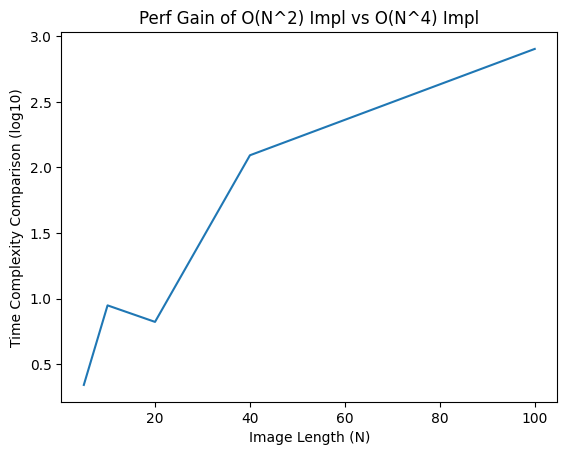

In [5]:
import matplotlib.pyplot as plt
import numpy as np


benchmark = {
    "N": [5, 10, 20, 40, 100],
    "o2": [179e-6, 649e-6, 899e-6, 10.9e-3, 65.5e-3],
    "o4": [393e-6, 5.76e-3, 5.97e-3, 1.35, 52.5],
}
plt.plot(benchmark["N"], np.log10(benchmark["o4"]) - np.log10(benchmark["o2"]))
plt.title("Perf Gain of O(N^2) Impl vs O(N^4) Impl")
plt.xlabel("Image Length (N)")
plt.ylabel("Time Complexity Comparison (log10)")
plt.show()

In [214]:
import numpy as np

m, n = 5, 5
A, B = np.random.randint(0, 256, size=(m, n)), np.random.randint(0, 256, size=(m, n))

In [215]:
%timeit -n 100 -r 10 _match_o2(A, B)

179 µs ± 21.7 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [216]:
%timeit -n 100 -r 10 _match_o4(A, B)

393 µs ± 20 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
